In [1]:
import keras
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
debug = True

In [3]:
path = 'data/driving_log.csv'

In [8]:
lines = []

def read_data_from_csv_file(csv_file):
    images, steering = [], []
    with open(csv_file) as csvfile:
        reader = csv.DictReader(csvfile)
        degrees = 10
        correction = degrees *0.01
        for row in reader:
            steering_value = float(row['steering'])
            images.append(row['center'])
            steering.append(steering_value)
            
            if (steering_value > 0.1 or steering_value < -0.1):
                # adding left camera images
                images.append(row['left'].strip())
                steering.append(steering_value + correction)
                # adding right camera images
                images.append(row['right'].strip())
                steering.append(steering_value - correction)
    return images, steering
   
images_raw, measurements = read_data_from_csv_file(path)

images = []

for i in range(len(images_raw)):
    images.append(cv2.imread("data/" + images_raw[i]))

print(images[1].shape)


(160, 320, 3)


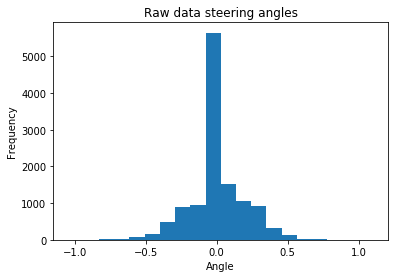

In [9]:
plt.hist(measurements, bins=20)
plt.title("Raw data steering angles")
plt.xlabel("Angle")
plt.ylabel("Frequency")
plt.show()

In [21]:
augmented_images, augmented_measurements = [], []
flipped_images, flipped_measurements = [], []

for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)

for image, measurement in zip(images, measurements):
    flipped_images.append(cv2.flip(image, 1))
    flipped_measurements.append(measurement * -1.0)
    
from random import randint

for i in range(int(len(flipped_measurements)/2)):
    random_int = randint(0, len(flipped_measurements) - 1)
    augmented_images.append(flipped_images[random_int])
    augmented_measurements.append(flipped_measurements[random_int])
    
    
x_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

if debug:
    print("The number of images augmented is: " + str(len(x_train)))

The number of images augmented is: 18393


In [22]:
print("The number of images augmented is: " + str(len(x_train)))    
print("The number of images augmented is: " + str(len(images)))

The number of images augmented is: 18393
The number of images augmented is: 12262


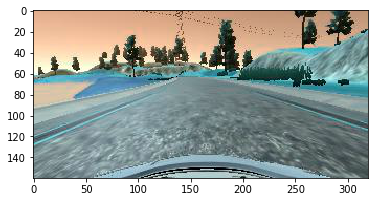

In [23]:
plt.imshow(shuffled_augmented_images[0])
plt.show()


In [24]:
print('Starting convolutional processing...')

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Activation, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

model.add(Convolution2D(32,3,3, activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Convolution2D(32,3,3, activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Convolution2D(64,3,3, activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
model.fit(x_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5)

model.save('model.h5')


Starting convolutional processing...
Train on 14714 samples, validate on 3679 samples
Epoch 1/5
14714/14714 [==============================] - 953s - loss: 0.0222 - val_loss: 0.0152